# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2020-09-25 05:26:31,524 INFO    : root         : Using LISA logging configuration:
2020-09-25 05:26:31,525 INFO    : root         :   /home/ubuntu/Android/lisa_old/logging.conf


In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript, display

from android import System

import subprocess

from systrace_parser import systrace_parser

2020-09-25 05:26:31,784 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2020-09-25 05:26:31,798 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa_old",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Filters

In [6]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
    'setSurface' : {
        'SMARK' : {'context' : 'setSurface', 'type' : 'B'}, 
        'EMARK' : {'context' : 'setSurface', 'type' : 'E'},
    },
}

In [7]:
def MismatchedStringWithoutNumber(comp1, comp2):
    comp1 = unicode(comp1)
    comp2 = unicode(comp2)
    count = 0
    for index in range(min(len(comp1), len(comp2))):
        if comp1[index] != comp2[index] and not comp1[index].isnumeric() and not comp1[index].isnumeric():
            count += 1
            
    return count
#print(MismatchedStringWithoutNumber('A207FSH9_POS_190822_190822_104817_calllog?', 'A207FSH9_POS_190822_180922_104475_calllog1'))

## Select systraces

In [8]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()
chboxes_descriptions = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            filename = filename[:-5]
            #print(filename)
            new_one = True
            for file_group in file_groups:
                #length_of_file = len(filename)
                #if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                if not MismatchedStringWithoutNumber(filename, file_group):
                    #print('before  {}'.format(file_groups))
                    #if not file_group.contains('[?]'):
                    #    file_groups.remove(file_group)
                        #file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #    file_groups.append('{}[?]'.format(file_group[:-3]))
                        #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)

    for file_group in file_groups:
        chboxes_descriptions.append('{}{}'.format(dirname, file_group))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1
    
chboxes_descriptions.sort()
#display(chboxes_descriptions)
for chboxes_description in chboxes_descriptions:
        chboxes.append(widgets.Checkbox(
                value=False,
                description=chboxes_description.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))

toggle = widgets.ToggleButton(
    description='START'
)

#chboxes[4].value = True
#chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnMTRJR1pVUC9hcXVlZHVjdHMnLCBsYXlvdXQ9TGF5b3V0KHdpZHRoPXUnMjAwJScpLCBzdHlsZT1EZXPigKY=


## Run cells

Please select over systrace files and press the run button to execute below cells.

In [11]:
def run_all(button):
    #get_ipython().run_cell()
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description=u'Run all below', style=ButtonStyle())

## Get file list

In [12]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        #length_of_file = len(file_path[-1])
        #new_file_path += file_path[-1][:-3] + '*.html'
        new_file_path += '*.html'
        #print(new_file_path)
        
        gathering_filelist = list()
        for dir_file in glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path):
            if not MismatchedStringWithoutNumber(file_path[-1], dir_file.split('/')[-1]):
                #print(dir_file)
                gathering_filelist.append(dir_file)
        filelist.append(gathering_filelist)
        #filelist[-1].sort()
        title += [file_path[-2] + "_" + file_path[-1]]

if len(filelist) == 0:
    raise  ValueError('Please select some groups of systrace in the over cell.')

Please select some systraces to analysis.

## Read Files

In [13]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [14]:
group1.run()
group2.run()

Parsing huawei_P30_Pro_taobao_2nd_2.html - 363260 lines are Ok
Parsing huawei_P30_Pro_taobao_2nd_1.html - 359671 lines are Ok
Parsing huawei_P30_Pro_taobao_trace_1st.html - 355157 lines are Ok


## Analysis

### The timing of marking data

The operation times of each trace_mark_filters.

In [15]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

W2020_huawei_P30_Pro_taobao_2nd_2


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1604.0,NaN,0.475,5.006,NaN,NaN,NaN,NaN,NaN
1606.0,NaN,0.876,0.369,NaN,NaN,NaN,NaN,NaN
1255.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1060.688
2027.0,0.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2349.0,0.645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7763.0,NaN,8.303,32.800,520.738,106.929,8.449,31.782,NaN
2163.0,NaN,2.346,0.092,NaN,NaN,NaN,NaN,NaN
7961.0,26.839,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1924.0,NaN,6.992,4.296,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
8032.0,32.799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1730.0,NaN,0.571,0.690,NaN,NaN,NaN,NaN,NaN
1731.0,NaN,0.771,0.441,NaN,NaN,NaN,NaN,NaN
2341.0,0.752,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021.0,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7954.0,NaN,0.104,0.145,NaN,NaN,NaN,NaN,NaN
2165.0,NaN,2.377,0.725,NaN,NaN,NaN,NaN,NaN
7832.0,NaN,6.730,21.503,506.63,96.823,10.1,25.64,NaN
1915.0,NaN,6.942,4.045,NaN,NaN,NaN,NaN,NaN


In [16]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

W2020_huawei_P30_Pro_taobao_trace_1st


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1572.0,NaN,0.635,5.136,NaN,NaN,NaN,NaN,NaN
1573.0,NaN,0.458,0.449,NaN,NaN,NaN,NaN,NaN
2023.0,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2376.0,0.548,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8220.0,NaN,9.404,40.863,553.735,148.243,10.846,50.17,NaN
1256.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1365.247
8178.0,NaN,NaN,NaN,252.858,NaN,14.196,NaN,NaN
1939.0,NaN,5.689,3.664,NaN,NaN,NaN,NaN,NaN
8444.0,33.797,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Launching Time(AVERAGE)

This section is showing the app launching time.

In [17]:
list_of_df = group1.get_marking_time()
sum_df1 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]

    if len(get_launching.index) :
        try :
            sum_df1 = pd.concat([sum_df1, get_launching])
        except :
            sum_df1 = get_launching

try :
    sum_df1 = sum_df1.replace(0, NaN).dropna(axis=1) * 1000
    sum_df1.loc['mean'] = sum_df1.mean()
except:
    print("No launching time")
    
list_of_df = group2.get_marking_time()
sum_df2 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        try :
            sum_df2 = pd.concat([sum_df2, get_launching])
        except :
            sum_df2 = get_launching

try :
    sum_df2 = sum_df2.replace(0, NaN).dropna(axis=1) * 1000
    sum_df2.loc['mean'] = sum_df2.mean()
except:
    print("No launching time")

No launching time
No launching time


In [18]:
display(pd.concat([sum_df1, sum_df2], keys=[group1.title, group2.title], sort=False))

launching
                                      pid              
W2020_huawei_P30_Pro_taobao_2nd_2     1255.0  1060.6880
                                      1247.0  1023.9990
                                      mean    1042.3435
W2020_huawei_P30_Pro_taobao_trace_1st 1256.0  1365.2470
                                      mean    1365.2470

### Process Time(AVERAGE)

Process time is from start to end timing within systrace tag of binadApplication / activityStart / ActivityThreadMain / ActivityResume.
 - time : total sum of time of running / runnable / sleeping / uninterruptible sleep.
 - running / runnable / sleeping / uninterruptible sleep : Process stat of cores.
 - setSurface : Just test and check the length of setSurface's tags.
 - launching : Sum of each tags, bindApplication, activityStart, ActivityThreadMain, activityResume, and Choreographer.

In [19]:
df1 = group1.get(systrace_parser.process_state()) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(systrace_parser.process_state()) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

In [20]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

setSurface  \
W2020_huawei_P30_Pro_taobao_2nd_2     time                                0   
                                      RUNNING                             0   
                                      RUNNABLE                            0   
                                      SLEEPING                            0   
                                      UNINTERUPTIBLE_SLEEP                0   
                                      UNINTERUPTIBLE_SLEEP(I/O)           0   
W2020_huawei_P30_Pro_taobao_trace_1st time                                0   
                                      RUNNING                             0   
                                      RUNNABLE                            0   
                                      SLEEPING                            0   
                                      UNINTERUPTIBLE_SLEEP                0   
                                      UNINTERUPTIBLE_SLEEP(I/O)           0   
DIFF                                  time                                0   
                                      RUNNING                             0   
                                      RUNNABLE                            0   
                                      SLEEPING                            0   
                                      UNINTERUPTIBLE_SLEEP                0   
                                      UNINTERUPTIBLE_SLEEP(I/O)           0   

                                                                 Choreographer #0  \
W2020_huawei_P30_Pro_taobao_2nd_2     time                                  7.516   
                                      RUNNING                               2.601   
                                      RUNNABLE                              0.807   
                                      SLEEPING                              2.988   
                                      UNINTERUPTIBLE_SLEEP                  1.121   
                                      UNINTERUPTIBLE_SLEEP(I/O)             0.000   
W2020_huawei_P30_Pro_taobao_trace_1st time                                  9.404   
                                      RUNNING                               2.310   
                                      RUNNABLE                              0.651   
                                      SLEEPING                              4.684   
                                      UNINTERUPTIBLE_SLEEP                  1.759   
                                      UNINTERUPTIBLE_SLEEP(I/O)             0.000   
DIFF                                  time                                 -1.888   
                                      RUNNING                               0.291   
                                      RUNNABLE                              0.156   
                                      SLEEPING                             -1.696   
                                      UNINTERUPTIBLE_SLEEP                 -0.638   
                                      UNINTERUPTIBLE_SLEEP(I/O)             0.000   

                                                                 Choreographer #1  \
W2020_huawei_P30_Pro_taobao_2nd_2     time                                 27.152   
                                      RUNNING                               0.857   
                                      RUNNABLE                              0.031   
                                      SLEEPING                             25.831   
                                      UNINTERUPTIBLE_SLEEP                  0.433   
                                      UNINTERUPTIBLE_SLEEP(I/O)             0.000   
W2020_huawei_P30_Pro_taobao_trace_1st time                                 40.863   
                                      RUNNING                               1.046   
                                      RUNNABLE                              0.053   
                                      SLEEPING                             38.660   
            

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
W2020_huawei_P30_Pro_taobao_2nd_2,time,0,7.516,27.152,513.684,101.876,9.274,28.711,0
W2020_huawei_P30_Pro_taobao_trace_1st,time,0,9.404,40.863,553.735,148.243,10.846,50.170,0
DIFF,time,0,-1.888,-13.711,-40.051,-46.367,-1.572,-21.459,0


### Processing time of setSurface

In [21]:
def ProcessingTime(group, index):
    result = dict()
    list_of_df = group.get_marking_time()
    sum = 0
    count = 0
    for df in list_of_df:
        df = df['setSurface'].fillna(0)
        max_value = df.max() * 1000
        sum += max_value
        count += 1
        result[count] = [max_value]
    #print("SUM : {}, AVG : {}".format(sum, sum/count))
    result['avg'] = [sum/count]
    
    df = DataFrame.from_dict(result)
    df.index = [group.title]
    return df

In [22]:
df1 = ProcessingTime(group1, 'setSurface')
df2 = ProcessingTime(group2, 'setSurface')
display(pd.concat([df1, df2]))

/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,1,2,avg
W2020_huawei_P30_Pro_taobao_2nd_2,26.839,32.799,29.819
W2020_huawei_P30_Pro_taobao_trace_1st,33.797,NaN,33.797


### Uninterruptible Sleep

The count of uninterruptible sleep within each tags.

In [23]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

In [24]:
print(group1.title)
display(df1)

W2020_huawei_P30_Pro_taobao_2nd_2


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
uninter_reason//SyS_munmap+0x30/0x70,0.0,0.0,1.5,8.0,0.0,0.0
uninter_reason//SyS_prctl+0x458/0x754,0.5,0.0,12.0,3.0,0.0,0.5
uninter_reason//__fdget_pos+0x40/0x54,0.0,0.0,0.0,0.5,0.0,0.0
uninter_reason//__get_user_pages_unlocked+0x54/0x1bc,0.0,0.0,0.0,2.0,0.0,0.0
uninter_reason//__percpu_down_read+0xfc/0x110,0.0,0.0,0.5,0.0,0.0,0.0
uninter_reason//binder_alloc_new_buf+0x34/0x610,0.0,0.0,0.0,0.0,0.0,0.0
uninter_reason//do_mprotect_pkey+0x98/0x230,1.0,0.5,25.0,6.5,0.0,1.5
uninter_reason//do_page_fault+0x17c/0x434,6.5,6.5,48.5,121.0,1.0,16.5
uninter_reason//vm_mmap_pgoff+0xa4/0xf8,2.5,0.0,27.0,17.0,0.0,3.0
uninter_reason_io//__lock_page+0x84/0xa8,0.0,0.0,4.0,0.0,0.0,0.0


In [25]:
print(group2.title)
display(df2)

W2020_huawei_P30_Pro_taobao_trace_1st


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
uninter_reason//SyS_munmap+0x30/0x70,0,0,7,9,0,0
uninter_reason//SyS_prctl+0x458/0x754,1,0,12,1,0,1
uninter_reason//__fdget_pos+0x40/0x54,0,0,0,0,0,0
uninter_reason//__get_user_pages_unlocked+0x54/0x1bc,0,0,0,1,0,0
uninter_reason//__percpu_down_read+0xfc/0x110,0,0,1,0,0,1
uninter_reason//binder_alloc_new_buf+0x34/0x610,0,0,0,1,0,0
uninter_reason//do_mprotect_pkey+0x98/0x230,0,0,50,5,0,2
uninter_reason//do_page_fault+0x17c/0x434,10,12,73,138,0,52
uninter_reason//vm_mmap_pgoff+0xa4/0xf8,2,0,38,18,0,3
uninter_reason_io//__lock_page+0x84/0xa8,0,0,9,0,0,0


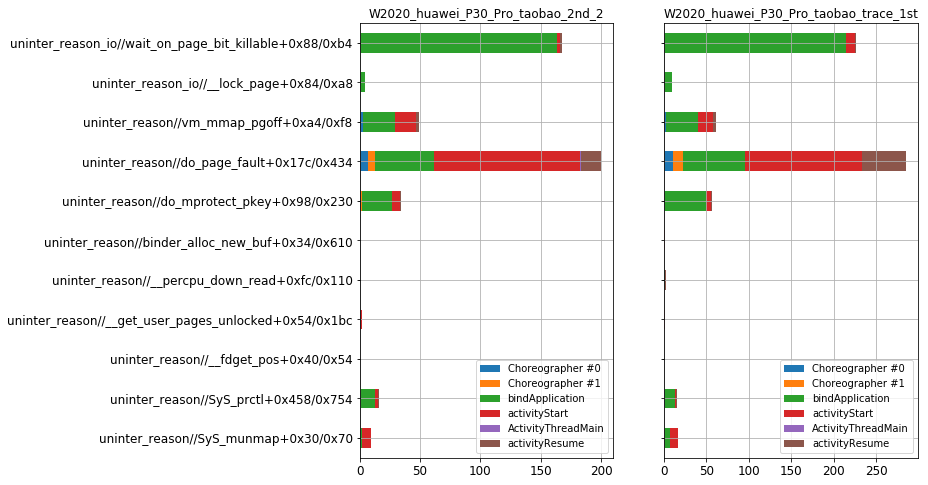

In [26]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)
df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

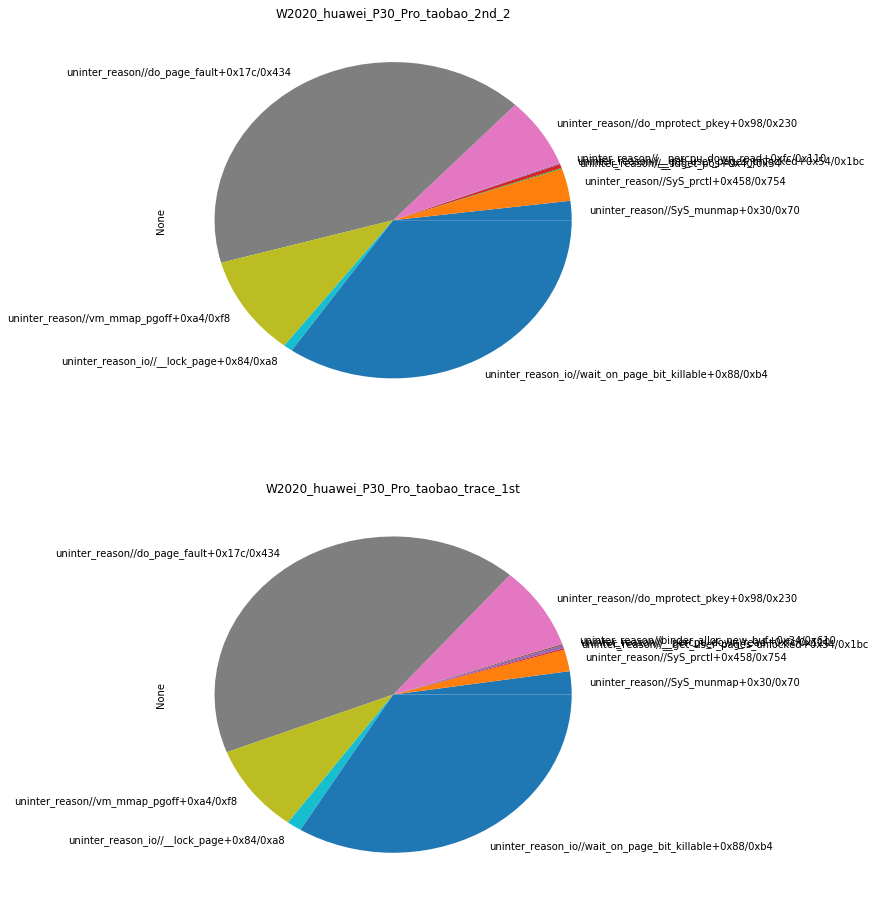

In [27]:
fig,axes = plt.subplots(nrows=2, ncols=1, sharey=True)
df1.sum(axis=1).plot(kind='pie', ax=axes[0], figsize=(8,16), title=group1.title)
df2.sum(axis=1).plot(kind='pie', ax=axes[1], figsize=(8,16), title=group2.title)

The number of count in each reason of uninterruptible sleep.

### Number of Running Cores(SUM)

The number of counting running cores when entering an app.

In [28]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
#display(df2)

In [29]:
display(pd.concat([df1, df2], keys=[group1.title, group2.title], sort=False))

Choreographer #0  \
6JHF19_APUS_atrace_APUSBrowser_iteration_1 core0                 1   
                                           core1                 1   
                                           core2                 1   
                                           core3                 0   
                                           core4                45   
                                           core5                50   
                                           core6                18   
                                           core7                31   
6JHF5_APUS_atrace_APUSBrowser_iteration_1  core0                 3   
                                           core1                 1   
                                           core2                 0   
                                           core3                 1   
                                           core4                21   
                                           core5                17   
                                           core6               106   
                                           core7                30   

                                                  Choreographer #1  \
6JHF19_APUS_atrace_APUSBrowser_iteration_1 core0                 0   
                                           core1                 0   
                                           core2                 0   
                                           core3                 0   
                                           core4                 1   
                                           core5                 1   
                                           core6                 4   
                                           core7                 4   
6JHF5_APUS_atrace_APUSBrowser_iteration_1  core0                 0   
                                           core1                 0   
                                           core2                 0   
                                           core3                 1   
                                           core4                 3   
                                           core5                 0   
                                           core6                 4   
                                           core7                 5   

                                                  activityStart  \
6JHF19_APUS_atrace_APUSBrowser_iteration_1 core0             10   
                                           core1              4   
                                           core2             11   
                                           core3             37   
                                           core4             12   
                                           core5             29   
                                           core6             40   
                                           core7             32   
6JHF5_APUS_atrace_APUSBrowser_iteration_1  core0             27   
                                           core1             28   
                                           core2              5   
                                           core3             21   
                                           core4             17   
                                           core5             24   
                                           core6             16   
                                           core7             27   

                                                  activityResume  
6JHF19_APUS_atrace_APUSBrowser_iteration_1 core0               0  
                                           core1               0  
                                           core2               0  
                                           core3               0  
                                           core4             909  
                                           core5             621  
                                           core6           

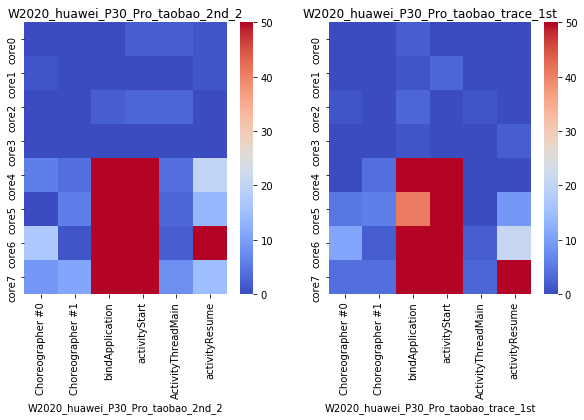

In [30]:
plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [31]:
print(group1.title)
for parser in group1.parsers_of_testing:
    display(parser.get(group1.cores()))

W2020_huawei_P30_Pro_taobao_2nd_2


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,0,1,1,0,NaN
core1,NaN,0,0,0,0,0,0,NaN
core2,NaN,0,0,1,2,0,0,NaN
core3,NaN,0,0,0,0,0,0,NaN
core4,NaN,4,0,60,59,1,11,NaN
core5,NaN,0,4,69,25,3,7,NaN
core6,NaN,14,1,242,124,1,33,NaN
core7,NaN,5,0,95,32,2,14,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,0,1,1,1,NaN
core1,NaN,1,0,0,0,0,1,NaN
core2,NaN,0,0,1,1,3,0,NaN
core3,NaN,0,0,0,0,0,0,NaN
core4,NaN,2,4,91,61,3,9,NaN
core5,NaN,0,2,53,42,0,7,NaN
core6,NaN,3,0,220,83,1,39,NaN
core7,NaN,4,11,70,103,6,1,NaN


In [32]:
print(group2.title)
for parser in group2.parsers_of_testing:
    display(parser.get(group2.cores()))

W2020_huawei_P30_Pro_taobao_trace_1st


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,2,0,0,0,NaN
core1,NaN,0,0,1,3,0,0,NaN
core2,NaN,1,0,3,0,1,0,NaN
core3,NaN,0,0,1,0,0,2,NaN
core4,NaN,0,4,60,70,0,0,NaN
core5,NaN,5,6,41,61,0,9,NaN
core6,NaN,11,2,342,112,2,21,NaN
core7,NaN,4,4,104,61,3,61,NaN


In [33]:
from systrace_parser import TAG_CORE_IDLE
def GetCoreStats(group):
    for parser in group.parsers_of_testing:
        rawdata = parser.get_rawdata('stat_core')
        index_key_list = list()
        df_list = list()
        
        for index_key in rawdata.keys():
            #print(index_key)
            index_key_list.append(index_key)

            core_state_dict = dict()
            for i in range(8):
                core_state_dict[i] = list()
            core_state_dict['selected'] = list()
            core_state_dict['time'] = list()

            for core_state in rawdata[index_key]:
                for i in range(8):
                    core_state_dict[i].append(core_state.get(i, TAG_CORE_IDLE))
                core_state_dict['selected'].append(core_state.get('selected', -1))
                core_state_dict['time'].append(core_state.get('time', -1))
            #display(DataFrame.from_dict(core_state_dict))
            df_list.append(DataFrame.from_dict(core_state_dict))

    return pd.concat(df_list, keys=index_key_list, sort=False).sort_values(by=['time'])
pd.set_option('display.max_rows', 500)

In [34]:
print(group1.title)
display(GetCoreStats(group1))

W2020_huawei_P30_Pro_taobao_2nd_2


0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0    I  R  I  I  I  I  I  V         7  356.246067
                   1    I  I  R  I  I  I  I  V         7  356.246432
                   2    I  R  R  I  I  R  I  V         7  356.246556
                   3    I  I  R  I  I  I  R  V         7  356.246800
                   4    I  I  R  I  I  R  I  V         7  356.247381
                   5    I  I  V  I  I  R  I  I         2  356.247412
                   6    I  I  V  I  R  R  I  I         2  356.247571
                   7    I  I  I  I  V  R  I  I         4  356.247592
                   8    R  I  I  I  V  R  I  R         4  356.247654
                   9    I  I  I  I  V  R  I  I         4  356.247846
                   10   V  I  I  I  I  R  I  I         0  356.248316
                   11   I  I  I  I  I  R  V  I         6  356.248407
                   12   I  I  V  R  I  I  I  I         2  356.251692
                   13   I  I  I  I  V  I  I  I         4  356.255469
bindApplication    0    I  I  I  I  I  R  R  V         7  356.263080
                   1    I  I  I  I  I  R  R  V         7  356.263117
                   2    I  I  I  I  I  R  R  V         7  356.263886
                   3    I  I  I  I  I  R  R  V         7  356.263981
                   4    I  I  I  I  I  I  R  V         7  356.264604
                   5    I  I  I  I  I  I  R  V         7  356.264721
                   6    I  I  I  I  I  V  R  I         5  356.264943
                   7    I  I  I  I  I  V  R  I         5  356.265143
                   8    I  R  I  I  R  V  R  I         5  356.265930
                   9    I  R  I  I  I  V  R  I         5  356.265993
                   10   R  R  R  I  I  V  R  I         5  356.266155
                   11   I  R  R  I  V  I  R  I         4  356.266224
                   12   I  I  I  I  V  I  R  I         4  356.266817
                   13   I  I  I  I  V  I  R  I         4  356.267406
                   14   I  I  I  I  V  R  R  R         4  356.267424
                   15   I  I  I  I  V  R  R  R         4  356.267443
                   16   I  I  I  I  V  R  R  R         4  356.267456
                   17   I  I  I  I  V  I  R  R         4  356.267468
                   18   I  I  I  I  V  R  R  I         4  356.267591
                   19   I  I  I  I  V  I  R  R         4  356.267616
                   20   I  I  I  I  V  I  R  I         4  356.267659
                   21   I  I  I  I  V  I  R  I         4  356.268313
                   22   I  I  I  I  V  I  R  I         4  356.268641
                   23   I  I  I  I  V  I  I  R         4  356.269502
                   24   I  I  I  I  V  I  I  R         4  356.269524
                   25   I  I  I  I  V  I  I  I         4  356.269570
                   26   I  I  I  I  V  I  I  I         4  356.269585
                   27   I  I  I  I  V  R  I  R         4  356.269602
                   28   I  I  I  I  V  R  I  R         4  356.269634
                   29   R  R  I  I  R  I  I  V         7  356.271831
                   30   I  I  R  I  V  I  I  R         4  356.274986
                   31   R  I  R  I  V  I  I  R         4  356.275234
                   32   I  R  R  I  V  I  I  R         4  356.275406
                   33   I  R  R  I  V  I  I  R         4  356.275565
                   34   I  R  R  I  R  V  I  R         5  356.275717
                   35   I  I  V  I  I  R  I  R         2  356.275881
                   36   I  I  I  I  I  V  I  R         5  356.276062
                   37   I  I  R  I  V  R  I  R         4  356.276221
                   38   I  I  R  I  I  V  I  R         5  356.276376
                   39   I  I  R  I  I  V  I  R         5  356.276533
                   40   I  I  R  I  V  R  I  R         4  356.276665
                   41   I  I  R  I  V  R  I  R         4  356.276815
                   42   I  I  R  I  V  I  I  R         4  356.276957
                   43 

In [35]:
print(group2.title)
display(GetCoreStats(group2))

W2020_huawei_P30_Pro_taobao_trace_1st


0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0    I  I  R  I  I  I  I  V         7  375.737363
                   1    I  R  I  R  R  I  I  V         7  375.737705
                   2    I  R  I  I  R  I  V  I         6  375.738328
                   3    I  I  I  I  I  I  V  I         6  375.738617
                   4    I  I  V  I  I  R  I  R         2  375.741877
                   5    I  I  R  R  I  R  V  I         6  375.746630
bindApplication    0    R  I  I  R  I  R  V  I         6  375.747150
                   1    R  I  I  I  I  I  V  I         6  375.747967
                   2    I  I  I  I  I  I  V  I         6  375.748073
                   3    I  I  R  I  I  I  V  I         6  375.748675
                   4    I  I  R  I  R  I  V  I         6  375.748880
                   5    I  I  R  I  I  I  V  I         6  375.749120
                   6    I  I  R  I  I  R  V  I         6  375.749273
                   7    I  V  I  I  I  I  I  I         1  375.750213
                   8    V  I  I  R  I  R  I  I         0  375.750273
                   9    R  I  I  R  I  V  I  I         5  375.750302
                   10   I  R  I  R  I  V  I  R         5  375.750375
                   11   I  I  I  R  I  V  I  I         5  375.750672
                   12   R  I  I  I  I  V  I  I         5  375.750737
                   13   I  I  R  I  R  V  I  I         5  375.751126
                   14   R  I  R  I  V  I  R  I         4  375.751209
                   15   R  I  I  I  I  V  R  I         5  375.752612
                   16   I  I  R  I  I  V  I  I         5  375.752672
                   17   I  I  R  I  I  V  R  I         5  375.752705
                   18   I  I  I  I  I  V  R  I         5  375.752741
                   19   I  I  I  I  I  V  R  R         5  375.752822
                   20   I  I  I  I  I  V  I  R         5  375.752852
                   21   I  I  I  I  I  V  I  I         5  375.752889
                   22   I  I  I  I  I  I  V  I         6  375.752975
                   23   I  I  I  I  I  R  V  I         6  375.753753
                   24   I  I  I  I  I  R  V  R         6  375.754250
                   25   I  I  I  I  I  R  V  I         6  375.754486
                   26   I  I  I  I  I  R  V  R         6  375.754501
                   27   I  I  I  I  I  R  V  R         6  375.754507
                   28   I  I  I  I  R  R  V  R         6  375.754523
                   29   I  I  I  I  I  R  V  R         6  375.754556
                   30   I  I  I  I  I  R  V  R         6  375.754568
                   31   I  I  I  I  R  R  V  R         6  375.754581
                   32   I  I  I  I  R  R  V  R         6  375.754592
                   33   I  I  I  I  I  R  V  R         6  375.754609
                   34   I  I  I  I  I  R  V  R         6  375.754620
                   35   I  I  I  I  I  R  V  R         6  375.754635
                   36   I  I  I  I  I  R  V  R         6  375.754645
                   37   I  I  I  I  R  R  V  R         6  375.754668
                   38   I  I  I  I  I  R  V  R         6  375.754690
                   39   I  I  I  I  R  R  V  R         6  375.754703
                   40   I  I  I  I  I  R  V  R         6  375.755278
                   41   I  I  I  I  R  R  V  R         6  375.755303
                   42   I  I  I  I  R  R  V  R         6  375.755316
                   43   I  I  I  I  R  R  V  R         6  375.755328
                   44   I  I  I  I  R  R  V  R         6  375.755355
                   45   I  I  I  I  R  R  V  R         6  375.755364
                   46   I  I  I  I  R  R  V  R         6  375.755374
                   47   I  I  I  I  I  R  V  R         6  375.755386
                   48   I  I  I  I  I  R  V  R         6  375.755396
                   49   I  I  I  I  R  R  V  R         6  375.755409
                   50   I  I  I  I  R  R  V  R         6  375.755432
                   51 

### Cpu Frequency

The graph to show a min lock status of core frequency.

In [36]:
from systrace_parser import CPU_FREQUENCY_LIMITS
def DrawCorrectedData(group, tyep_filter, data_label, func):
    prevalue = dict()
    list_of_df_for_start = group.get_marking_time(dtype='start')
    list_of_df_for_end = group.get_marking_time(dtype='end')
    idx = 0

    for item in group.get(tyep_filter, func='array'):
        df = DataFrame(item, columns=['cpu_id', 'time', data_label])
        df = df.apply(pd.to_numeric)
        
        ### to darw launcging time ++
        min_freq = df[data_label].min()
        prevalue['launching'] = min_freq
        
        if len(list_of_df_for_start) > idx:
            launching_time = list_of_df_for_start[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time, 
                           data_label : ((min_freq + 1) * 2)}, ignore_index=True) 
        if len(list_of_df_for_end) > idx:
            launching_time = list_of_df_for_end[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time,
                           data_label : min_freq}, ignore_index=True)
        ### to darw launcging time --
        
        if func != 0:
            df = func(df)
            
        length = len(df.index)
            
        for i in range(length):
            #display(df.iloc[i])
            if df.iloc[i]['cpu_id'] in prevalue.keys():
                df = df.append({'cpu_id' : df.iloc[i]['cpu_id'], 
                           'time' : (df.iloc[i]['time'] - 0.000001), 
                           data_label : prevalue[df.iloc[i]['cpu_id']]}, ignore_index=True) 
                #display(df.iloc[i])
            prevalue[df.iloc[i]['cpu_id']] = df.iloc[i][data_label]
        
        idx += 1
        df.index = df['time']
        df = df.sort_index()
        df.groupby(['cpu_id'])[data_label].plot(legend=True, figsize=(15,4))
        plt.show()

W2020_huawei_P30_Pro_taobao_2nd_2


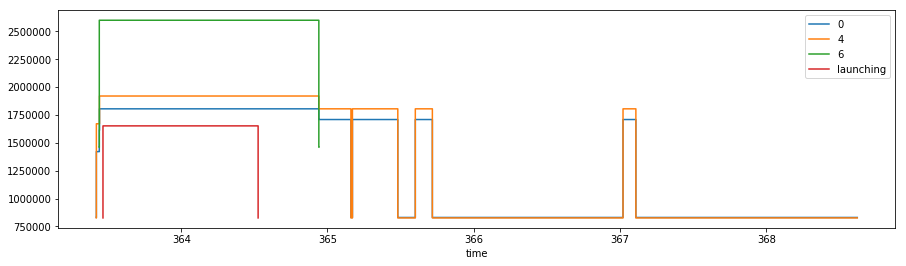

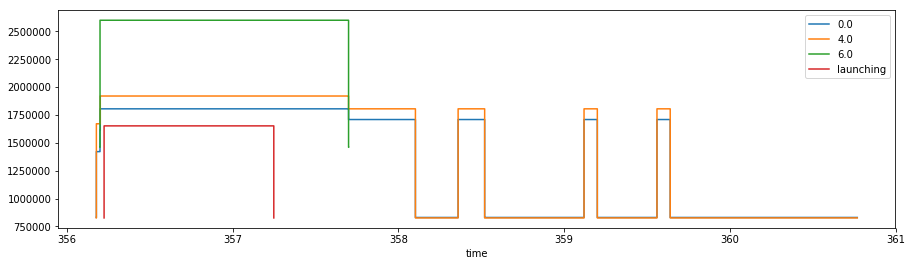

In [37]:
print(group1.title)
DrawCorrectedData(group1, CPU_FREQUENCY_LIMITS, 'min', 0)

W2020_huawei_P30_Pro_taobao_trace_1st


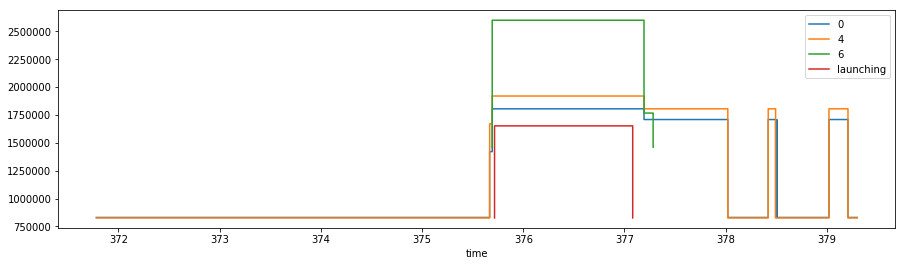

In [38]:
print(group2.title)
DrawCorrectedData(group2, CPU_FREQUENCY_LIMITS, 'min', 0)

### Cpu Idle

The graph to show a min lock status of core Idle.

In [39]:
from systrace_parser import CPU_IDLE
def PreprocessingForCPUIDLE(df):
    try :
        df_launching = df[df.cpu_id == 'launching']
    except :
        df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

        df.loc[df.state >= 4294967295, 'state'] = -1
        df['state'] = df['state'] + 1
        
        return df

    df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

    df.loc[df.state >= 4294967295, 'state'] = -1
    df['state'] = df['state'] + 1
    
    df = df[df.time >= (df_launching['time'].iloc[0] - 0.1)]
    df = df[df.time <= (df_launching['time'].iloc[1] + 0.1)]
    
    df = pd.concat([df, df_launching])
    return df

W2020_huawei_P30_Pro_taobao_2nd_2


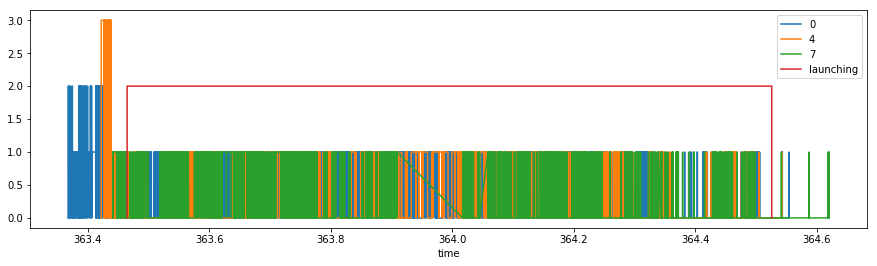

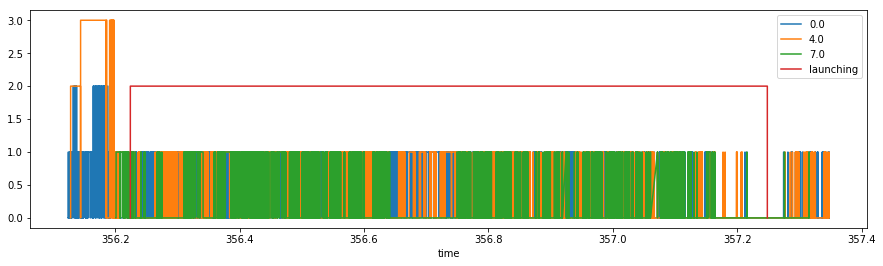

In [40]:
print(group1.title)
DrawCorrectedData(group1, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

W2020_huawei_P30_Pro_taobao_trace_1st


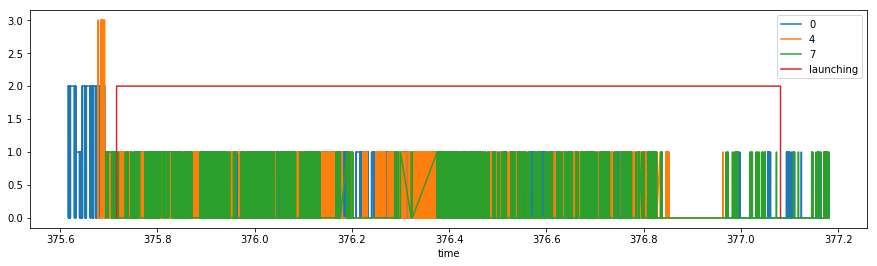

In [41]:
print(group2.title)
DrawCorrectedData(group2, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

### Lock Contention

In [42]:
df1 = group1.get(['lock_contention']) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(['lock_contention']) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

In [43]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
#display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
W2020_huawei_P30_Pro_taobao_2nd_2,lock_contention,0,0,15.949,195.507,23.806,1.877,6.946,0
W2020_huawei_P30_Pro_taobao_trace_1st,lock_contention,0,0,29.040,227.822,17.476,4.736,16.594,0
DIFF,lock_contention,0,0,-13.091,-32.315,6.330,-2.859,-9.648,0


In [44]:
def DrawLockContention(parser):
    for lock_contention in parser.storage_lock_contention:
        lock_contention['owner'] = lock_contention['context'].split('owner ')[1].split(' waiters')[0]
        lock_contention['blocking'] = lock_contention['context'].split('blocking from')[1]
    df = DataFrame.from_dict(parser.storage_lock_contention)
    df.loc[df['duration'] > 0, 'duration'] *= 1000

    return df
        #if value == 'NaN':
            
        #else:
        #    display(DataFrame(df[value].value_counts()))

Liminated the lock contentions by the main thread is sleepping in an app.
(The effection means that lock contentions seem to effect to the app entry because the process stat was sleep.)

In [45]:
#for parser in group.parsers_of_testing:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df1 = df[df['effection'] == 'O']
display(group1.title)
display(df1.sort_values(by=['duration'], ascending=False))

u'W2020_huawei_P30_Pro_taobao_2nd_2'

,blocking,context,duration,effection,owner,pid,time,type
53,java.lang.Object com.alibaba.wireless.securit...,monitor contention with owner MTOPSDK DefaultP...,44.491,O,MTOPSDK DefaultPool Thread:1 (7868),7871,363.819556,B
193,tb.bme com.taobao.alivfssdk.fresco.cache.disk...,monitor contention with owner Phenix-Scheduler...,35.527,O,Phenix-Scheduler3 (7997),7993,364.398527,B
54,boolean mtopsdk.mtop.intf.Mtop.checkMtopSDKIn...,monitor contention with owner MTOPSDK DefaultP...,33.965,O,MTOPSDK DefaultPool Thread:1 (7868),7880,363.840305,B
194,java.util.List com.taobao.alivfssdk.fresco.ca...,monitor contention with owner AVFSDiskCache #p...,32.460,O,AVFSDiskCache #phximgs_top3 (8028),8005,364.401961,B
196,java.util.List com.taobao.alivfssdk.fresco.ca...,monitor contention with owner AVFSDiskCache #p...,27.759,O,AVFSDiskCache #phximgs_top3 (8028),7997,364.407812,B
195,java.util.List com.taobao.alivfssdk.fresco.ca...,monitor contention with owner AVFSDiskCache #p...,27.500,O,AVFSDiskCache #phximgs_top3 (8028),8026,364.407173,B
197,java.util.List com.taobao.alivfssdk.fresco.ca...,monitor contention with owner AVFSDiskCache #p...,22.540,O,AVFSDiskCache #phximgs_top3 (8028),7995,364.412837,B
98,android.content.SharedPreferences android.app...,monitor contention with owner tb.ank$1@4bd1ef0...,14.034,O,tb.ank$1@4bd1ef0 (7841),7833,364.043998,B
99,android.content.SharedPreferences android.app...,monitor contention with owner tb.ank$1@4bd1ef0...,14.004,O,tb.ank$1@4bd1ef0 (7841),7837,364.044219,B
163,java.util.List com.taobao.alivfssdk.fresco.ca...,monitor contention with owner AVFSDiskCache #p...,10.075,O,AVFSDiskCache #phximgs_top1 (7996),7995,364.213646,B


In [46]:
#for parser in group.parsers_of_testing:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df2 = df[df['effection'] == 'O']
display(group2.title)
display(df2.sort_values(by=['duration'], ascending=False))

u'W2020_huawei_P30_Pro_taobao_trace_1st'

,blocking,context,duration,effection,owner,pid,time,type
420,void com.loc.bu.a(android.content.Context)(Ta...,monitor contention with owner amapLocManagerTh...,94.703,O,amapLocManagerThread (8536),8530,377.275679,B
421,java.lang.String com.taobao.wireless.security...,monitor contention with owner spdy-0 (8266) wa...,47.633,O,spdy-0 (8266),8535,377.301420,B
416,java.lang.String com.taobao.wireless.security...,monitor contention with owner KernelThread-2 (...,29.679,O,KernelThread-2 (8334),8535,377.247231,B
117,void java.lang.Runtime.loadLibrary0(java.lang...,monitor contention with owner DCDataCollector ...,24.359,O,DCDataCollector (8403),8404,376.302013,B
121,void java.lang.Runtime.loadLibrary0(java.lang...,monitor contention with owner Thread-11 (8404)...,23.542,O,Thread-11 (8404),8403,376.337874,B
323,java.util.List com.taobao.alivfssdk.fresco.ca...,monitor contention with owner AVFSDiskCache #p...,23.019,O,AVFSDiskCache #phximgs_top3 (8512),8484,376.888125,B
132,void java.lang.Runtime.loadLibrary0(java.lang...,monitor contention with owner bootimage pre-In...,22.873,O,bootimage pre-Init (8406),8403,376.370044,B
126,void java.lang.Runtime.loadLibrary0(java.lang...,monitor contention with owner Thread-11 (8404)...,20.949,O,Thread-11 (8404),8406,376.349069,B
370,tb.bme com.taobao.alivfssdk.fresco.cache.disk...,monitor contention with owner Phenix-Scheduler...,16.968,O,Phenix-Scheduler5 (8486),8467,376.973077,B
327,java.util.List com.taobao.alivfssdk.fresco.ca...,monitor contention with owner AVFSDiskCache #p...,16.331,O,AVFSDiskCache #phximgs_top3 (8512),8467,376.898875,B


In [47]:
display(group1.title)
display(df1['duration'].sum())

u'W2020_huawei_P30_Pro_taobao_2nd_2'

372.9529999998249

In [48]:
display(group2.title)
display(df2['duration'].sum())

u'W2020_huawei_P30_Pro_taobao_trace_1st'

692.1240000003195

Sum of the lock contention's duration. The durations could be duplicated.

Liminated the lock contentions by owners.

In [49]:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group1.title)
display(DataFrame(df['owner'].value_counts()))

u'6JHF19_APUS_atrace_APUSBrowser_iteration_1'

,owner
Binder:1230_D (2866) at java.util.List com.android.server.am.ActivityManagerService.getRunningAppProcesses()(ActivityManagerService.java:11170),5
android.anim (1409) at void com.android.server.wm.InputMonitor$1.run()(InputMonitor.java:125),5
android.anim (1409) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:141),5
"Binder:1230_A (2232) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2194)",5
"android.display (1405) at void com.android.server.am.ActivityManagerService$LocalService.updateActivityUsageStatsWithIntent(android.content.ComponentName, int, int, android.os.IBinder, android.content.ComponentName, android.content.Intent)(ActivityManagerService.java:20040)",3
Binder:1230_D (2866) at void com.android.server.wm.ActivityTaskManagerService.activityPaused(android.os.IBinder)(ActivityTaskManagerService.java:2297),3
"android.display (1405) at void com.android.server.wm.ActivityMetricsLogger.checkVisibility(com.android.server.wm.TaskRecord, com.android.server.wm.ActivityRecord)(ActivityMetricsLogger.java:575)",3
"Binder:1230_D (2866) at boolean com.android.server.wm.ActivityTaskManagerService$LocalService.isGetTasksAllowed(java.lang.String, int, int)(ActivityTaskManagerService.java:7534)",3
android.anim (1409) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:132),3
android.anim (1409) at void com.android.server.wm.WindowSurfacePlacer.lambda$new$0$WindowSurfacePlacer()(WindowSurfacePlacer.java:65),3


In [50]:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group2.title)
display(DataFrame(df['owner'].value_counts()))

u'6JHF5_APUS_atrace_APUSBrowser_iteration_1'

,owner
android.anim (5906) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:141),5
Binder:5806_12 (7397) at boolean com.android.server.am.ActivityManagerService.unbindService(android.app.IServiceConnection)(ActivityManagerService.java:15717),5
"Binder:5806_1 (5845) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2194)",4
"main (6236) at boolean android.os.MessageQueue.enqueueMessage(android.os.Message, long)(MessageQueue.java:556)",4
"android.ui (5880) at boolean com.android.server.wm.ActivityTaskManagerService$LocalService.isGetTasksAllowed(java.lang.String, int, int)(ActivityTaskManagerService.java:7529)",3
"android.ui (5880) at java.util.List com.android.server.wm.ActivityTaskManagerService.getFilteredTasks(int, int, int)(ActivityTaskManagerService.java:3259)",3
"Binder:5806_9 (6369) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2194)",3
android.display (5901) at void com.android.server.wm.WindowManagerService$H.handleMessage(android.os.Message)(WindowManagerService.java:5249),3
Binder:5806_1 (5845) at java.util.List com.android.server.am.ActivityManagerService.getRunningAppProcesses()(ActivityManagerService.java:11170),2
"android.display (5901) at void com.android.server.am.ActivityManagerService$LocalService.updateActivityUsageStatsWithIntent(android.content.ComponentName, int, int, android.os.IBinder, android.content.ComponentName, android.content.Intent)(ActivityManagerService.java:20040)",2


Text(0,0.5,'weight')

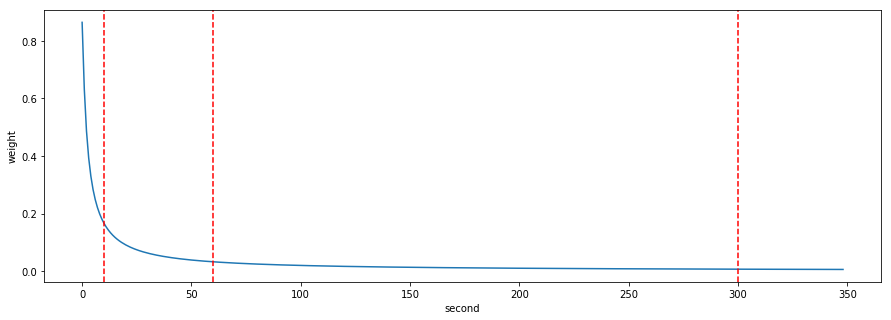

In [51]:
from math import exp


#display(np.exp(-2.0/np.arange(1,300.0)) * 2048)
plt.figure(figsize=(15,5))
plt.plot(1 - np.exp(-2.0/np.arange(1,350.0)))
plt.axvline(x=10, color='r', linestyle='--')
plt.axvline(x=60, color='r', linestyle='--')
plt.axvline(x=300, color='r', linestyle='--')
plt.xlabel('second')
plt.ylabel('weight')